Explore whitening of the ${\bf x} = \xi({\bf r})$ or $P({\bf k})$ data. For convenience (data in hand) I will use $P({\bf k})$. 

In [13]:
import numpy as np 
# -- local -- 
import env
import data as Data
import util as UT
# -- plotting -- 
import matplotlib.pyplot as plt 
from ChangTools.plotting import prettyplot
from ChangTools.plotting import prettycolors
% matplotlib inline 

Construct data $N_{mock} \times N_{k}$ matrix ${\bf X}$ using `Nseries` mock catalog $P(k)$ measurements

In [9]:
pkay = Data.Pk()
for i in range(1,85): 
    pkay.Read('nseries', i)
    k, pk = pkay.k, pkay.pk
    if i == 1: 
        X = np.zeros((84, len(k)))
    X[i-1,:] = pk

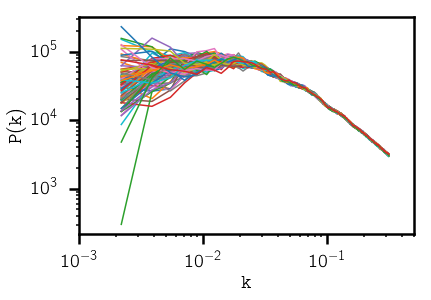

In [12]:
# check X
prettyplot()
pretty_colors = prettycolors()
fig = plt.figure()
sub = fig.add_subplot(111)
for i in range(X.shape[0]): 
    sub.plot(k, X[i,:])
sub.set_xscale('log')
sub.set_xlim([1e-3, 0.5])
sub.set_xlabel('$\mathtt{k}$', fontsize=20)
sub.set_yscale('log')
sub.set_ylabel('$\mathtt{P(k)}$', fontsize=20)

In [16]:
# calculate the covariance matrix
C_x = np.cov(X.T)

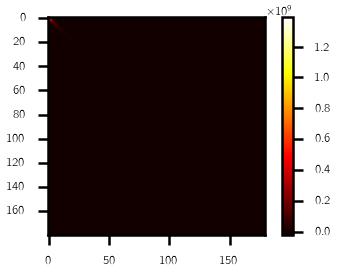

In [17]:
im = plt.imshow(C_x, interpolation="None", cmap='hot')
plt.colorbar(im)